# Fine-tuned YAMNet: small plane detection

In [1]:
import pyaudio, librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Decide what type of messages are displayed by TensorFlow (ERROR, WARN, INFO, DEBUG, FATAL)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
## TensorFlow memory allocation options:
# OPTION 1: "smart" allocation
#config=tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sess=tf.Session(config=config) 

# OPTION 2: maximum memory allocation per session (0-1 = 0-100%)
gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# OPTION 3: ???
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# OPTION 4: ???
#Slim/embedded versions: (https://github.com/google-research/tf-slim)

print("tf version: ", tf.__version__)
print("tf.keras version: ", tf.keras.__version__)

tf version:  1.15.0
tf.keras version:  2.2.4-tf


In [3]:
## Add/append required paths
import os, sys

path_root = '/home/ups/Proyectos/Vigia_sonido/Models/yamnet_planes/' #path to main folder
# path_root = input("Enter the path of your repository: ") # ask user for path_root
assert os.path.exists(path_root)
sys.path.append(path_root)

path_yamnet_original = path_root+'/yamnet_original/' #path to original yamnet files
assert os.path.exists(path_yamnet_original)
sys.path.append(path_yamnet_original)

In [4]:
## YAMNet (original) is only used to extract class names
import yamnet as yamnet_original

class_names = yamnet_original.class_names(path_yamnet_original+'yamnet_class_map.csv')

In [6]:
## Modified YAMNet model for feature extraction (and YAMNet visualisation)
import modified_yamnet as yamnet_modified
import params

params.PATCH_HOP_SECONDS = 0.48 #low values: higher accuracy but higher computational cost

yamnet_features = yamnet_modified.yamnet_frames_model(params)
yamnet_features.load_weights(path_root+'yamnet.h5')

In [9]:
#TEMP
# Load waveform
DESIRED_SR = params.SAMPLE_RATE # required by YAMNet

file_name = "/home/ups/Proyectos/Vigia_sonido/Datasets/airplanes_v0/training_data/plane/track_04_0000_norm.wav"
waveform = read_wav(file_name, DESIRED_SR, use_rosa=1)
waveform = waveform[0:4*DESIRED_SR]

print('Waveform size:', waveform.shape, 'and duration:', waveform.shape[0]/DESIRED_SR, '[s]')

# Calculate scores and spectrogram
spectrogram, _, _, scores = yamnet_features.predict(np.reshape(waveform, [1, -1]), steps=1)

print('Spectrogram size:',spectrogram.shape)
print('Scores size:',scores.shape)


Waveform size: (64000,) and duration: 4.0 [s]
Spectrogram size: (398, 64)
Scores size: (7, 521)


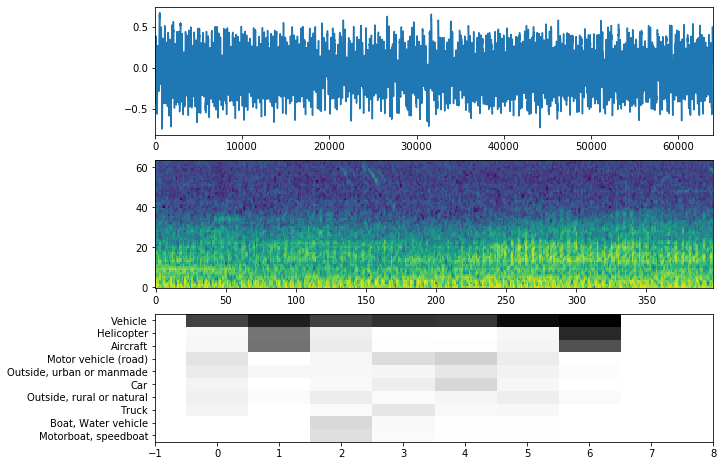

In [10]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))

plt.show()

## Function definitions

In [8]:
def read_wav(fname, output_sr, use_rosa=True):
    # small wrapper - i was seeing some slightly different 
    # results when loading with different libraries 
    if use_rosa:
        waveform, sr = librosa.load(fname, sr=output_sr)
    else:
        wav_data, sr = sf.read(fname, dtype=np.int16)
        
        if wav_data.ndim > 1: 
            # (ns, 2)
            wav_data = wav_data.mean(1)
        if sr != output_sr:
            wav_data = resampy.resample(wav_data, sr, output_sr)
        waveform = wav_data / 32768.0
    
    return waveform.astype(np.float64)


In [ ]:
def remove_silence(waveform, top_db=15, min_chunk_size=2000, merge_chunks=True):
    # Loads sample into chunks of non-silence 
    
    splits = librosa.effects.split(waveform, top_db=top_db)
    
    waves = []
    for start, end in splits:
        if (end-start) < min_chunk_size:
            continue
        waves.append(waveform[start:end])
    
    if merge_chunks:
        out = None
        for c in waves:
            if out is None:
                out = c.copy()
            else:
                out = np.concatenate((out, c))
        waves = out
    
    return waves


In [ ]:
def get_top_dirs(p):
    dirs = list(filter(lambda x : os.path.isdir( os.path.join(p, x) ), os.listdir(p)))
    return list(map(lambda x : os.path.join(p, x), dirs))

In [ ]:
def random_augment_wav(wav_data):
    # apply some random augmentations to the sound
    # - time stretch, resample, volume change, minor noise 
    # - this has not been evaluated to measure contributions
    # - TODO: probably a lot more augmentations you could use 
    
    wav_data = wav_data.copy() 
    
    # random re-sample 
    if np.random.uniform() > 0.8:
        stretch = np.random.uniform(0.75, 1.5)
        wav_data = librosa.effects.time_stretch(wav_data, stretch)
    elif np.random.uniform() > 0.2:
        new_sr = int(DESIRED_SR * np.random.uniform(0.9, 1.1))
        wav_data = resampy.resample(wav_data, DESIRED_SR, new_sr)
    
    #librosa.effects.pitch_shift()
    
    # random volume
    volume = np.random.uniform(0.65, 1.2)
    wav_data = wav_data * volume
    
    # Random noise
    if np.random.uniform() > 0.5:
        NR = 0.001 # 0.1
        wav_data += np.random.uniform(-NR, NR, size=wav_data.shape)
    
    return wav_data

In [ ]:
import glob, resampy
from tqdm import tqdm

def load_data(base_path, 
              yamnet_features, 
              num_augmentations=5,
              max_sample_seconds=5.0,
              use_rosa=True):
    """
    Loads data from .wav files contained in subfolders where 
    folder name is label, then runs them 
    through the audio_model to get feature vectors 
    and returns:
    
    X : [ np.array(1024) , ... ]
    Y : [ category_idx , ...]
    
    """
    
    label_dirs = get_top_dirs(base_path)
    
    _samples = []
    _labels = []
    
    merge_chunks = True
    MIN_WAV_SIZE = 5000 # TODO: seems to need to be pretty long for NN to work?
    max_wav_size = int(DESIRED_SR * max_sample_seconds)
    
    for label_idx, label_dir in enumerate(label_dirs):
        
        label_name = os.path.basename(label_dir)
        wavs = glob.glob(os.path.join(label_dir, "*.wav"))
        print(" Loading {:<5} '{:<40}'".format(label_idx, label_name))

        for wav_file in tqdm(wavs):
            
            # rosa seems very different?
            #for use_rosa in range(2):
            if True:
                #use_rosa = 1
                #use_rosa = np.random.uniform() > 0.5
                waveform = read_wav(wav_file, DESIRED_SR, use_rosa=use_rosa)

                if label_name == 'train':
                    waveform = remove_silence(waveform)

                if len(waveform) < MIN_WAV_SIZE:
                    continue 

                if len(waveform) > max_wav_size:
                    waveform = waveform[:max_wav_size]
                    print("\nIgnoring audio data after {} seconds".format(max_sample_seconds))

                for aug_idx in range(1 + num_augmentations):
                    
                    aug_wav = waveform.copy()
                    
                    if aug_idx > 0:
                        aug_wav = random_augment_wav(aug_wav)

                    _, _, dense_out, _ = yamnet_features.predict(np.reshape(aug_wav, [1, -1]), steps=1)
                    
                    for patch in dense_out:
                        _samples.append(patch)
                        _labels.append(label_idx)
                
    return _samples, _labels

In [ ]:
def run_models(waveform, 
               yamnet_features, 
               top_model, 
               strip_silence=True, 
               min_samples=16000):
    
    if strip_silence:
        waveform = remove_silence(waveform, top_db=10)
    
    if len(waveform) < min_samples:
        print("input too short after silence removal")
        return [-1] #this value will be used to discard this audio later
    
    _, _, dense_out, _ = yamnet_features.predict(np.reshape(waveform, [1, -1]), steps=1)
    
    # dense = (N, 1024)
    all_scores = []
    for patch in dense_out:
        scores = top_model.predict(np.expand_dims(patch,0)).squeeze()
        all_scores.append(scores)
        
    all_scores = np.mean(all_scores, axis=0)
    return all_scores

## YAMNet (original) predictions on a single audio

In [ ]:
# Load waveform
DESIRED_SR = params.SAMPLE_RATE # required by YAMNet

file_name = "/home/ups/Proyectos/Vigia_sonido/Datasets/airplanes_v0/training_data/plane/track_04_0000_norm.wav"
waveform = read_wav(file_name, DESIRED_SR, use_rosa=1)

# Calculate scores and spectrogram
spectrogram, _, _, scores = yamnet_features.predict(np.reshape(waveform, [1, -1]), steps=1)

In [ ]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))

plt.show()

## Load training data


In [ ]:
samples, labels = load_data("/home/ups/Proyectos/Vigia_sonido/Datasets/airplanes_v2/training_data/",
                            yamnet_features,
                            num_augmentations=4, 
                            max_sample_seconds=5.0)


In [ ]:
import random

idxs = list(range(len(labels)))
random.shuffle(idxs)

samples = [samples[i] for i in idxs]
labels = [labels[i] for i in idxs]

samples = np.array(samples)
labels = np.array(labels)

print(" Loaded samples: " , samples.shape, samples.dtype,  labels.shape)


## Classifier which takes YAMNet's feature vector as input

In [ ]:
from tensorflow.keras import Model, layers

def yamnet_classifier(num_classes=2, 
                  input_size=1024,
                  num_hidden=1024):

    input_layer = layers.Input(shape=(input_size,))    
    output = layers.Dense(num_hidden, activation=None)(input_layer)
    output = layers.Dense(num_classes, activation='softmax')(output)
    model = Model(inputs=input_layer, outputs=output)
    
    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
save_best = ModelCheckpoint('top_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')


In [ ]:
from tensorflow.keras.optimizers import SGD, Adam

# Classifier definition
NUM_CLASSES = 2
feature_len = 1024
num_hidden = 1024

yamnet_planes = yamnet_classifier(num_classes=NUM_CLASSES, 
                      input_size=feature_len, 
                      num_hidden=num_hidden)

#opt = Adam(learning_rate=0.001)
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

yamnet_planes.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model 
history = yamnet_planes.fit(samples, labels, epochs=200, validation_split=0.1)
# history = yamnet_planes.fit(samples, labels, epochs=200, validation_split=0.1, callbacks=[save_best])

In [ ]:
# Load model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam

yamnet_planes = load_model(path_root+'top_model_v2.h5')
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
yamnet_planes.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
yamnet_planes.summary()

## Test on holdout sounds

In [ ]:
## Specify feature extraction parameters
NUM_CLASSES = 2 #["not plane", "plane"]
categories = ["not plane", "plane"]
frame_len = int(params.SAMPLE_RATE * 1) # 1sec

In [ ]:
# Scores for a single holdout audio
file_name = "/home/ups/Proyectos/Vigia_sonido/Datasets/airplanes_v2/holdout_data/plane/track_04_0000_norm.wav"
waveform = read_wav(file_name, DESIRED_SR, use_rosa=1)

scores = run_models(waveform, yamnet_features, yamnet_planes)
winner = categories[scores.argmax()]

print(" Best score: {}  label: {}".format(scores.max(), winner))

In [ ]:
# Scores for a holdout folder
holdout_dir = "/home/ups/Proyectos/Vigia_sonido/Datasets/airplanes_v2/holdout_data/plane/"
arr = os.listdir(holdout_dir)

for fname in arr: 
    fname = holdout_dir+fname
    waveform = read_wav(fname, DESIRED_SR, use_rosa=1)

    # waveform = remove_silence(waveform, top_db=10)

    # make file a bit longer by duplicating it 
    waveform = np.concatenate((waveform,waveform,waveform))

    scores = run_models(waveform, yamnet_features, yamnet_planes, strip_silence=False)
    winner_save = np.empty((0,2))
    if scores[0] != -1:
        winner = categories[scores.argmax()]
        print(" Best score: {}  label: {}".format(scores.max(), winner))
        # winner_save = np.append(winner_save,np.array([scores.max(),winner]),axis=0)

In [ ]:
# result_array = np.empty((0, 2))
# result = np.array([1,"a"])
# result_array = np.append(result_array, [result], axis=0)
# result_array = np.append(result_array, [result], axis=0)

# result_array

In [ ]:
## Save the model for later
model.save("top_model_v2.h5", include_optimizer=False)